In [1]:
import numpy as np
import pandas as pd
import os
import glob
import joblib

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from nilearn import plotting 
from nilearn.image import smooth_img, swap_img_hemispheres, resample_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.input_data import NiftiMasker
import nibabel as nib

import scipy.stats
from scipy.stats import pearsonr, spearmanr, ttest_ind
import statsmodels.api as sm

import llms_brain_lateralization as lbl
from llms_brain_lateralization import make_dir

np.random.seed(1234)

rc={'font.size': 12, 'axes.labelsize': 14, 
    'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(rc=rc)
sns.set_style('darkgrid')

In [2]:
save_fig = True

In [3]:
if save_fig:
    fig_folder = lbl.figures_folder
    make_dir(fig_folder)

In [4]:
nifti_masker = NiftiMasker(mask_img='mask_lpp_en.nii.gz')
nifti_masker.fit()
n_voxels = nifti_masker.n_elements_

print(n_voxels)

25870


In [5]:
glm_folder = lbl.llms_brain_correlations

df_model_info = pd.read_csv('model_info_en.csv', index_col=0)
df_model_info = df_model_info[df_model_info['model_name'].str.startswith('Qwen')|df_model_info['model_name'].str.startswith('gpt')]

model_names = df_model_info['model_name'].to_numpy()
n_parameters = df_model_info['n_parameters'].to_numpy()
n_layers_models = df_model_info['n_layers'].to_numpy() + 1 # +1 because of the embedding layer

idx_sort_params = np.argsort(n_parameters)

model_names = model_names[idx_sort_params]
n_layers_models = n_layers_models[idx_sort_params]
n_parameters = n_parameters[idx_sort_params]

n_models = len(model_names)

In [6]:
corr_layers_voxels_models = []
for model_name, n_layers in zip(model_names, n_layers_models):
    corr_layers_voxels = []
    for idx_layer in range(n_layers):
        filename = os.path.join(glm_folder, '{}_layer-{}_corr_en.gz'.format(model_name, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))

In [7]:
corr_layers_voxels_models_untrained = []
for model_name, n_layers in zip(model_names, n_layers_models):
    corr_layers_voxels = []
    for idx_layer in range(n_layers):
        filename = os.path.join(glm_folder, '{}_untrained_seed1_layer-{}_corr_en.gz'.format(model_name, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models_untrained.append(np.array(corr_layers_voxels))

In [8]:
# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) 
                               for corr_layers_voxels in corr_layers_voxels_models])

corr_voxels_models_untrained = np.array([np.max(corr_layers_voxels, axis=0) 
                                         for corr_layers_voxels in corr_layers_voxels_models_untrained])

# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

corr_l_models_untrained = corr_voxels_models_untrained[:,:n_voxels//2]
corr_r_models_untrained = corr_voxels_models_untrained[:,n_voxels//2:]

# inter-subject correlation (isc)
filename = 'isc_10trials_en.gz'
isc_10trials = joblib.load(filename)
isc = np.mean(isc_10trials, axis=0)

is_voxel_reliable = isc > np.percentile(isc, 75)

#### rv for reliable voxels

# mean correlation for each voxel, for each model, using best layer for each voxel
# n_models x n_voxels
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])
corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

corr_voxels_models_untrained_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models_untrained])
corr_l_models_untrained_rv = corr_l_models_untrained[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_untrained_rv = corr_r_models_untrained[:,is_voxel_reliable[n_voxels//2:]]

In [9]:
title_family = {'gpt':'GPT-2', 'opt':'OPT', 'Lla':'Llama 2', 'Qwe':'Qwen1.5', 
                 'gem':'Gemma', 'sta':'StableLM', 'Mis':'Mistral', 'mam':'Mamba'}
model_family = np.array([title_family[model_name[:3]] for model_name in model_names])

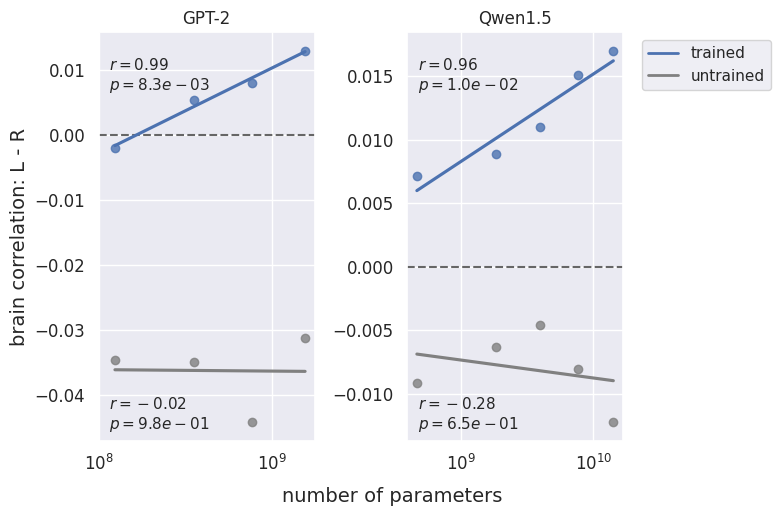

In [10]:
# on the most 25% reliable voxels

fh, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False)
for i, model_name in enumerate(np.unique(model_family)):
    ax = axes[i]
    sns.regplot(x=n_parameters[model_family==model_name], 
                y=(np.mean(corr_l_models_rv[model_family==model_name], axis=1)
                   -np.mean(corr_r_models_rv[model_family==model_name], axis=1)), 
                ci=None,
                logx=True, ax=ax);
    r, p = pearsonr(np.log(n_parameters[model_family==model_name]),
                    (np.mean(corr_l_models_rv[model_family==model_name], axis=1)
                     -np.mean(corr_r_models_rv[model_family==model_name], axis=1)))
    ax.text(0.05, 0.94,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
                ha='left', va='top', fontsize=11, transform=ax.transAxes)

    sns.regplot(x=n_parameters[model_family==model_name], 
                y=(np.mean(corr_l_models_untrained_rv[model_family==model_name], axis=1)
                   -np.mean(corr_r_models_untrained_rv[model_family==model_name], axis=1)), 
                ci=None, color='0.5',
                logx=True, ax=ax);
    r, p = pearsonr(np.log(n_parameters[model_family==model_name]), 
                    (np.mean(corr_l_models_untrained_rv[model_family==model_name], axis=1)
                     -np.mean(corr_r_models_untrained_rv[model_family==model_name], axis=1)))
    ax.text(0.05, 0.11,'$r={:.2f}$\n$p={:.1e}$'.format(r,p),
                ha='left', va='top', fontsize=11, transform=ax.transAxes)
    ax.set_xscale('log')   
    ax.axhline(0., ls='--', c='0.4', zorder=1);
    ax.set_title(model_name)
axes[0].set_xticks([1.e+08, 1.e+09])
axes[0].set_ylabel('brain correlation: L - R')
fh.text(0.5, -0.02, 'number of parameters', ha='center', fontsize=14)
plt.plot([], c='b', lw=2, label='trained')
plt.plot([], c='0.5', lw=2, label='untrained')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'braincorr_l_minus_r_trained_vs_untrained.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))

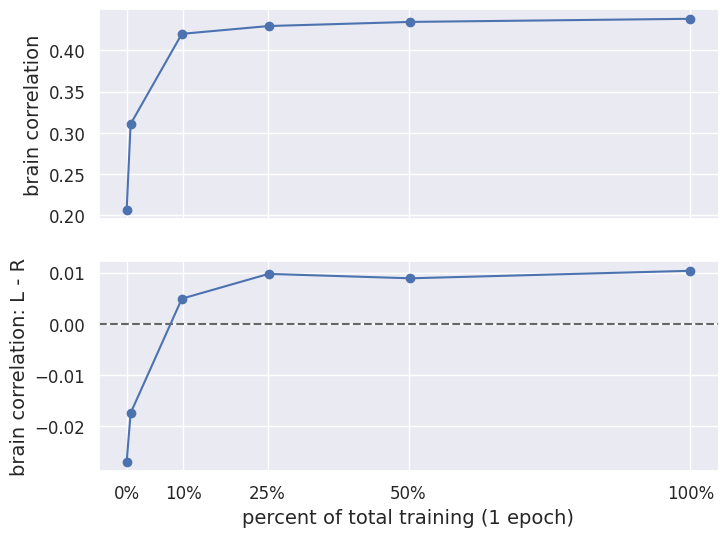

In [11]:
model_name = 'pythia-6.9b'
steps = [0, 1000, 14000, 36000, 72000, 143000]

n_layers = 32+1

corr_layers_voxels_models = []
for step in steps:
    corr_layers_voxels = []
    for idx_layer in range(n_layers):
        filename = os.path.join(glm_folder, '{}_step{}_layer-{}_corr_en.gz'.format(model_name, step, idx_layer))
        with open(filename, 'rb') as f:
            corr_voxels = joblib.load(f)
        corr_layers_voxels.append(corr_voxels)
    corr_layers_voxels_models.append(np.array(corr_layers_voxels))

corr_voxels_models = np.array([np.max(corr_layers_voxels, axis=0) 
                               for corr_layers_voxels in corr_layers_voxels_models])
corr_voxels_models_rv = np.array([np.max(corr_layers_voxels[:,is_voxel_reliable], axis=0)
                                  for corr_layers_voxels in corr_layers_voxels_models])
# restrict to left and right hemisphere
corr_l_models = corr_voxels_models[:,:n_voxels//2]
corr_r_models = corr_voxels_models[:,n_voxels//2:]

corr_l_models_rv = corr_l_models[:,is_voxel_reliable[:n_voxels//2]]
corr_r_models_rv = corr_r_models[:,is_voxel_reliable[n_voxels//2:]]

fh, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=False)
ax = axes[0]
ax.plot(steps, np.mean(corr_voxels_models_rv, axis=1), '-o')
ax = axes[1]
ax.plot(steps, (np.mean(corr_l_models_rv, axis=1)-np.mean(corr_r_models_rv, axis=1)), '-o')
ax.set_xticks(np.array([0, 10, 25, 50, 100])/100*143000, ['{}%'.format(i) for i in [0, 10, 25, 50, 100]])
ax.axhline(0., ls='--', c='0.4', zorder=1);
axes[1].set_xlabel('percent of total training (1 epoch)')
axes[0].set_ylabel('brain correlation')
axes[1].set_ylabel('brain correlation: L - R')
plt.show()

if save_fig:
    fh.savefig(os.path.join(fig_folder, 'pythia_training.pdf'), bbox_inches='tight', facecolor=(1,1,1,0))